# Entscheidungsbäume und Random Forest

### Module importieren

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score


### Daten einlesen

In [2]:
spam_df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/openintro/email.csv', index_col=0)

### Variable Explanation
| Variable | Explanation |
|--- | --- |
| spam | Indicator for whether the email was spam. |
| to_multiple | Indicator for whether the email was addressed to more than one recipient. |
| from | Whether the message was listed as from anyone (this is usually set by default for regular outgoing email). |
| cc | Number of people cc'ed. |
| sent_email | Indicator for whether the sender had been sent an email in the last 30 days. |
| time | Time at which email was sent. |
| image | The number of images attached. |
| attach | The number of attached files. |
| dollar | The number of times a dollar sign or the word “dollar” appeared in the email. |
| winner | Indicates whether “winner” appeared in the email. |
| inherit | The number of times “inherit” (or an extension, such as “inheritance”) appeared in the email. |
| viagra | The number of times “viagra” appeared in the email. |
| password | The number of times “password” appeared in the email. |
| num_char | The number of characters in the email, in thousands. |
| line_breaks | The number of line breaks in the email (does not count text wrapping). |
| format | Indicates whether the email was written using HTML (e.g. may have included bolding or active links). |
| re_subj | Whether the subject started with “Re:”, “RE:”, “re:”, or “rE:” |
| exclaim_subj | Whether there was an exclamation point in the subject. |
| urgent_subj | Whether the word “urgent” was in the email subject. |
| exclaim_mess | The number of exclamation points in the email message. |
| number | Factor variable saying whether there was no number, a small number (under 1 million), or a big number. |


### Überblick über Daten bekommen

In [3]:
spam_df.head()

,spam,to_multiple,from,cc,sent_email,time,image,attach,dollar,winner,...,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess,number
1,0,0,1,0,0,2012-01-01 01:16:41,0,0,0,no,...,0,0,11.370,202,1,0,0,0,0,big
2,0,0,1,0,0,2012-01-01 02:03:59,0,0,0,no,...,0,0,10.504,202,1,0,0,0,1,small
3,0,0,1,0,0,2012-01-01 11:00:32,0,0,4,no,...,0,0,7.773,192,1,0,0,0,6,small
4,0,0,1,0,0,2012-01-01 04:09:49,0,0,0,no,...,0,0,13.256,255,1,0,0,0,48,small
5,0,0,1,0,0,2012-01-01 05:00:01,0,0,0,no,...,0,2,1.231,29,0,0,0,0,1,none


In [4]:
spam_df.describe().round(2)

,spam,to_multiple,from,cc,sent_email,image,attach,dollar,inherit,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess
count,3921.00,3921.00,3921.00,3921.00,3921.00,3921.00,3921.00,3921.00,3921.00,3921.00,3921.00,3921.00,3921.00,3921.00,3921.00,3921.00,3921.00,3921.00
mean,0.09,0.16,1.00,0.40,0.28,0.05,0.13,1.47,0.04,0.00,0.11,10.71,230.66,0.70,0.26,0.08,0.00,6.58
std,0.29,0.36,0.03,2.67,0.45,0.45,0.72,5.02,0.27,0.13,0.96,14.65,319.30,0.46,0.44,0.27,0.04,51.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.46,34.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.86,119.00,1.00,0.00,0.00,0.00,1.00
75%,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,14.08,298.00,1.00,1.00,0.00,0.00,4.00
max,1.00,1.00,1.00,68.00,1.00,20.00,21.00,64.00,9.00,8.00,28.00,190.09,4022.00,1.00,1.00,1.00,1.00,1236.00


### Daten vorbereiten

In [5]:
random_seed = 5

In [6]:
spam_df.drop(columns='time', inplace=True)

#### Binäre kategoriale Variablen in Dummy Variablen umwandeln (0-1-Encodierung) 

In [7]:
spam_df = pd.get_dummies(spam_df, columns=['winner', 'number'], drop_first=True)


#### Downsampling
Maßnahme gegen ungleichmäßige Verteilung der Targetlabel

In [8]:
num_spam_labels = spam_df.spam.sum()

spam_df_downsampled = spam_df.groupby('spam').sample(n=num_spam_labels, random_state=random_seed).reset_index(drop=True)

#### Für Training, Umwandlung der Pandas Dataframes zu Numpy Arrays und Separierung von Zielvariable und restlichen Daten

In [9]:
y = spam_df_downsampled['spam'].to_numpy()
X = spam_df_downsampled.drop(columns='spam').to_numpy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=random_seed)

## Entscheidungsbaum (decission tree)

### Modell Training

Initialisieren Sie `DecisionTreeClassifier` und probieren Sie verschiedene Parameter aus. Fügen Sie auch `random_state=random_seed` als Parameter dazu um sicherzustellen, dass Ihr Ergebnis wiederholbar ist. Wichtige Parameter können bspw. `max_depth`,  `min_samples_split`, oder `max_features` sein. Nutzen Sie anschließend `fit` um das Modell mit `X_train` und `y_train` zu trainieren.

In [11]:
tree_model = DecisionTreeClassifier(max_depth=5, max_features=6, random_state=random_seed)

In [12]:
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_features=6, random_state=5)

### Modell anwenden

Erstellen Sie nun vorhersagen mit dem Modell. Nutzen Sie `predict` um die Klassen des Testsets vorherzusagen.

In [13]:
y_pred_tree = tree_model.predict(X_test)
y_pred_tree_train = tree_model.predict(X_train)

### Modell Validierung

Im letzten Schritt können Sie mit den folgenden Zeilen ihr Modell validieren und sehen ob es die gewünschte Accuracy erreicht.

In [14]:
test_accuracy_tree = accuracy_score(y_test, y_pred_tree)
simple_benchmark_accuracy = accuracy_score(y_test, np.ones_like(y_test))

In [15]:
results = pd.DataFrame([test_accuracy_tree, simple_benchmark_accuracy], columns=['Accuracy'], index=['Test', 'Benchmark']).round(3)
results

,Accuracy
Test,0.790
Benchmark,0.502


### Modell Visualisierung

Ein Vorteil der Entscheidungsbäume ist, dass sie im Gegensatz zu bspw. Random Forest relativ leicht interpretierbar sind. Nutzen Sie die sklearn.tree Funktion `plot_tree()` um den trainierten Entscheidungsbaum zu zeichnen. Nutzen Sie dabei die Parameter `feature_names`, `class_names`, `filled` und `fontsize` auf eine Weise, die Sie für sinnvoll halten. 

In [27]:
feature_names = spam_df.columns[1:].to_list()

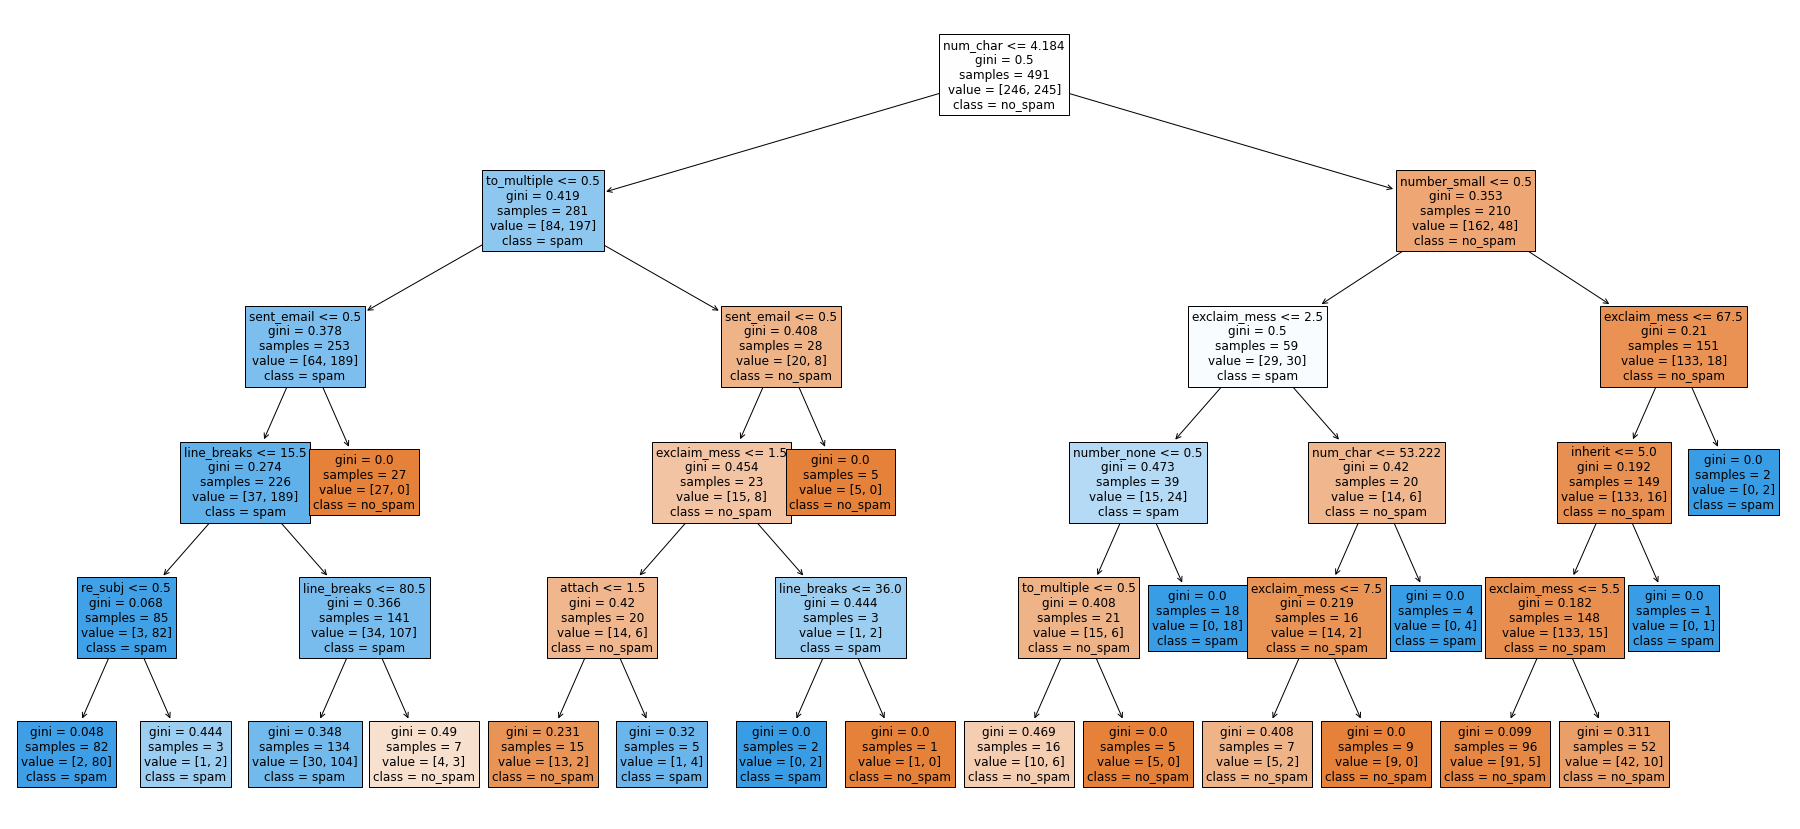

In [37]:
plt.figure(figsize=(32,15))
plot_tree(tree_model, feature_names=feature_names, class_names=['no_spam', 'spam'], filled=True, fontsize=12)
plt.show()

## Random Forest

### Modell Training

Wie zuvor, initialisieren Sie zuerst das Modell und trainieren es danach. Diesmal mit `RandomForestClassifier`. Zuzüglich zu den Decision Tree Parametern gibt es jetzt auch `n_estimators`. Versuchen Sie eine Accuracy zu erreichen die mindestens höher als die des einzelnen Entscheidungsbaums und idealerweise über 0.81 liegt.

In [16]:
rf_model = RandomForestClassifier(100, max_depth=15, max_features=6, random_state=random_seed)

In [17]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=6, random_state=5)

### Modell anwenden

Vorhersagen funktionieren wie zuvor. speichern Sie sie unter `y_pred_rf`

In [18]:
y_pred_rf = rf_model.predict(X_test)

### Modell Validierung

Im letzten Schritt können Sie mit den folgenden Zeilen ihr Modell validieren.

In [19]:
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
simple_benchmark_accuracy = accuracy_score(y_test, np.ones_like(y_test))

In [20]:
results = pd.DataFrame([test_accuracy_rf, simple_benchmark_accuracy], columns=['Accuracy'], index=['Test', 'Benchmark']).round(3)
results

,Accuracy
Test,0.835
Benchmark,0.502


## Zusatzaufgabe

Versuchen Sie aus einzelnen Entscheidungsbäumen (`DecisionTreeClassifier`) Ihr eigenes Random Forest Modell zu bauen. Sie können dafür die gegebenen Funktionshüllen verwenden wenn Sie möchten oder Ihre eigene Struktur wählen.
Beachten Sie dabei, dass 2 wichtige Faktoren um von einem Decission Tree zu einem Random Forest zu gelangen die Anzahl an Bäumen und das Bootstrapping der Daten ist. Mit Bootstrapping ist das wiederholte ziehen zufälliger Reihen aus dem Datensatz mit zurücklegen gemeint, sprich eine Reihe kann mehrmals gezogen werden, während eine andere eventuell garnicht gezogen wird.

Fokusieren Sie sich bei dieser Aufgabe vor Allem auf die Apsekte des Modells, die Sie auch hier verwendet haben. Es müssen nicht alle Parameter und Optionen des scikit-learn Modells vorhanden sein, bspw. muss Ihr RF nicht parallelisierbar sein.

Um zufällige Sample zu ziehen sind die Funktionen des `np.random` Modul sehr nützlich.

In [21]:
def bootstrap_sampling(X, y, num_samples):
    '''Sampling randomly rows/values from X/y with replacement'''
    random_ids =  np.random.choice(num_samples, size=num_samples, replace=True)
    X_rd_sample, y_rd_sample = X[random_ids, :], y[random_ids]
    return X_rd_sample, y_rd_sample

Bedenken Sie, dass das RF-Modell erst am Ende Klassen ausgeben sollte. Zuvor ist es besser mit Wahrscheinlichkeitsschätzungen zu arbeiten, sprich `predict_proba` zu nutzen. Wenn Sie die gegebene Funktion verwenden, denken Sie zudem daran *params durch geeignete Parameter zu ersetzen.

In [22]:
def fit_predict_tree(X_train, y_train, X_test, max_depth, max_features, size_bootstrap_sample):
    '''Fits decision tree to bootstrapped train data with given parameters and predicts probability estimates on test data'''
    tree = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features)

    X_train_rd, y_train_rd = bootstrap_sampling(X_train, y_train, size_bootstrap_sample)

    tree.fit(X_train_rd, y_train_rd)

    y_pred = tree.predict_proba(X_test)[:, 1]

    return y_pred

Zuletzt muss nur noch die gewählte Anzahl an Entscheidungsbäumen trainiert werden um dann jeweils das Testset vorherzusagen. Von den Vorhersagen kann dann der Durchschnitt berechnet werden.

In [23]:
def fit_predict_rf(X_train, y_train, X_test,
                   n_estimators, max_depth, max_features, size_bootstrap_sample):
    '''Fits random forest to train data with given parameters and predicts classes and probability estimates on test data'''
    tree_predictions = []
    for i in range(n_estimators):
        y_pred_i = fit_predict_tree(X_train, y_train, X_test, max_depth, max_features, size_bootstrap_sample)
        tree_predictions.append(y_pred_i.reshape(-1, 1))

    y_pred_prob = np.mean(np.concatenate(tree_predictions, axis=1), axis=1)
    y_pred = np.mean(np.concatenate(tree_predictions, axis=1), axis=1).round()

    return y_pred, y_pred_prob

Die folgende Zeile sollte am Ende idealerweise die Klassen- (`y_pred_custom_rf`) und die Wahrscheinlichkeitsschätzungen (`y_pred_prob_custom_rf`) ausgeben.

In [24]:
np.random.seed(5)
y_pred_custom_rf, y_pred_prob_custom_rf = fit_predict_rf(X_train, y_train, X_test, n_estimators=100, max_depth=15, max_features=6, size_bootstrap_sample=len(X_train))

### Modell Validierung

Validierung wie zuvor.

In [25]:
test_accuracy_custom_rf = accuracy_score(y_test, y_pred_custom_rf)

In [26]:
results = pd.DataFrame([test_accuracy_custom_rf, simple_benchmark_accuracy], columns=['Accuracy'], index=['Test', 'Benchmark']).round(3)
results

,Accuracy
Test,0.831
Benchmark,0.502


## Zusätzliche Validierung

In [27]:
y_pred_rf_train = rf_model.predict(X_train)

y_pred_tree_train = tree_model.predict(X_train)

# Wahrscheinlichkeitsschätzungen für Spam, also Label 1 auswählen
y_pred_prob_tree = tree_model.predict_proba(X_test)[:, 1]
y_pred_prob_tree_train = tree_model.predict_proba(X_train)[:, 1]

y_pred_prob_rf_train = rf_model.predict_proba(X_train)[:, 1]
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

Accuracy und AUC auf Train- und Testset für Entscheidungsbaum und Random Forest berechnen  

In [28]:
train_accuracy_tree = accuracy_score(y_train, y_pred_tree_train)
test_accuracy_tree = accuracy_score(y_test, y_pred_tree)

train_accuracy_rf = accuracy_score(y_train, y_pred_rf_train)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)

In [29]:
train_auc_tree = roc_auc_score(y_train, y_pred_prob_tree_train)
test_auc_tree = roc_auc_score(y_test, y_pred_prob_tree)

train_auc_rf = roc_auc_score(y_train, y_pred_prob_rf_train)
test_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

test_auc_custom_rf = roc_auc_score(y_test, y_pred_prob_custom_rf)

In [30]:
simple_benchmark_accuracy = accuracy_score(y_test, np.ones_like(y_test))
simple_benchmark_auc = roc_auc_score(y_test, np.ones_like(y_test))

In [31]:

results_extensive = [[train_accuracy_tree, train_auc_tree],[test_accuracy_tree, test_auc_tree],
                     [train_accuracy_rf, train_auc_rf], [test_accuracy_rf, test_auc_rf],
                     [test_accuracy_custom_rf, test_auc_custom_rf],
                     [simple_benchmark_accuracy, simple_benchmark_auc]]

index_labels = ['Train decision tree', 'Test decision tree', 'Train random forest', 'Test random forest', 'Test custom RF', 'Benchmark']
results_extensive_df = pd.DataFrame(results_extensive, columns=['Accuracy', 'AUC'], index=index_labels).round(3)
results_extensive_df

,Accuracy,AUC
Train decision tree,0.874,0.930
Test decision tree,0.790,0.832
Train random forest,0.998,1.000
Test random forest,0.835,0.898
Test custom RF,0.831,0.890
Benchmark,0.502,0.500
